#Intro
**Jon Messier**\
Dec 2022

The goal of this project is to help the grocery store company predict sales.  We are given a dataset, but not much insight to the values beyond what is included in the Data Dictionary below.  

For this project, an Exploratory Data Analysis (EDA) of the set will be made to validate the quality of the data in the set.  The EDA will include visual and numerical review of key features to observe the correlation to `Item_Outlet_Sales`, our target feature.  

Once, key features are identified, models will be created and trained to forecast sales.  The model explored here are:
- Linear Regression
- Dummy (Mean Regression)
- Decision Tree
- Bagged Tree
- Random Forest

Finally a recomendation will be made for a model type to help predict sales.


#Data Dictionary

<table><tbody><tr><td><strong>Variable Name</strong></td><td><strong>Description</strong></td></tr><tr><td>Item_Identifier</td><td>Unique product ID</td></tr><tr><td>Item_Weight</td><td>Weight of product</td></tr><tr><td>Item_Fat_Content</td><td>Whether the product is low fat or regular</td></tr><tr><td>Item_Visibility</td><td>The percentage of total display area of all products in a store allocated to the particular product</td></tr><tr><td>Item_Type</td><td>The category to which the product belongs</td></tr><tr><td>Item_MRP</td><td>Maximum Retail Price (list price) of the product</td></tr><tr><td>Outlet_Identifier</td><td>Unique store ID</td></tr><tr><td>Outlet_Establishment_Year</td><td>The year in which store was established</td></tr><tr><td>Outlet_Size</td><td>The size of the store in terms of ground area covered</td></tr><tr><td>Outlet_Location_Type</td><td>The type of area in which the store is located</td></tr><tr><td>Outlet_Type</td><td>Whether the outlet is a grocery store or some sort of supermarket</td></tr><tr><td>Item_Outlet_Sales</td><td>Sales of the product in the particular store. This is the target variable to be predicted.</a></td></tr></tbody></table>

#Library Import

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

#Plotting
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import matplotlib as mpl
plt.style.library['seaborn-darkgrid']

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_selector
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer

# Models
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor

# Regression Metrics
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

# Set global scikit-learn configuration 
from sklearn import set_config
# Display estimators as a diagram
set_config(display='diagram') # 'text' or 'diagram'}

#Custom Functions

##`evaluate_model`

In [2]:
# Create a function to take the true and predicted values
# and print MAE, MSE, RMSE, and R2 metrics
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name=''):
  train_predictions = model.predict(X_train)
  test_predictions = model.predict(X_test)
  print(f'{model_name} evaluation: ')
  #MAE
  train_mae = mean_absolute_error(y_train, train_predictions)
  test_mae = mean_absolute_error(y_test, test_predictions)
  print(f'Train MAE = {train_mae}')
  print(f'Test MAE = {test_mae}')
  #MSE
  train_mse = mean_squared_error(y_train, train_predictions)
  test_mse = mean_squared_error(y_test, test_predictions)
  print(f'Train MSE = {train_mse}')
  print(f'Test MSE = {test_mse}')
  #RMSE
  train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
  test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
  print(f'Train RMSE = {train_rmse}')
  print(f'Test RMSE = {test_rmse}')
  #R2
  train_r2 = r2_score(y_train, train_predictions)
  test_r2 = r2_score(y_test, test_predictions)
  print(f'Train R2 = {train_r2}')
  print(f'Test R2 = {test_r2}')
  report = {'Model':model_name,'Train_MAE': train_mae,'Train_MSE': train_mse, 'Train_RMSE':train_rmse, 'Train_R2':train_r2,
            'Test_MAE': test_mae, 'Test_MAE': test_mse, 'Test_RMSE':train_rmse, 'Test_R2':test_r2}

  return report

##`df_inspect`

In [3]:
#Define an inspection function to report for duplicates, and Nan values
#remove duplicates and output list of nan counts and total
def df_inspect(df):
  if df.duplicated().sum() >>0:
    print(f'The total number of duplicates are : {df.duplicated().sum()}\n')
    df.drop_duplicates(inplace=True)
    print('All duplicate entries have been removed.\n')
  print(f'There are no duplicate entries.\n')
  #Nan values
  print(f'The total number of NaN-values is:{df.isna().sum().sum()}')
  print(f'The NaN-values are found in the following features:')
  print(df.isna().sum())
  #shape
  print(f'\nThere are {df.shape[0]} rows, and {df.shape[1]} columns.')
  print(f'The rows represent {df.shape[0]} observations, and the columns represent {df.shape[1]-1} features and 1 target variable.\n')
  print(df.info())
  print(f'\nThe column names are:\n {df.columns}')

##`plot_charts`

In [4]:
def plot_charts(df, col, boxplot = False):
 if boxplot:
  ## make the figure and axes sharing the same x-axis
  fig, axes = plt.subplots(nrows=2, figsize=(10,3), sharex=True)

  ## Use seaborn plots with ax=axes[i]
  #Histogram axes[0]
  sns.histplot(data=df,x = col,ax = axes[0])
  #add the mean to the histogram
  mean_value = df[col].mean()
  axes[0].axvline(mean_value,color='red', ls='--', 
            label=f"Mean Value = ${mean_value:,.2f}",);
  #add the median to the histogram
  med_value = df[col].median()
  axes[0].axvline(med_value,color='black', ls='--', 
            label=f"Median Value = ${med_value:,.2f}");

  #boxplot -- axes[1]
  sns.boxplot(data=df, x = col, ax = axes[1])

  ## Updating title of top graph 
  axes[0].set_title(f'Histogram and Box plot for {col}')

# Turn off the comparitive boxplot  
 else:
   fig, axes = plt.subplots(figsize=(10,3))
   plt.xticks(rotation=45)
   sns.histplot(data=df,x=col, color='#69b3a2', alpha=0.3, ax=axes)
      
 ## Fixing any overlapping labels and showing
 plt.tight_layout()
 plt.show()

##`hundred_k`, `million_m` - Style Formatting

In [5]:
#Convert formatting on X-tick marks
def hundred_k(x,pos):
    """function for use wth matplotlib FuncFormatter -  formats money in thousands"""
    return f"${x*1e-3:,.0f}K"

def million_m(x,pos):
    """function for use wth matplotlib FuncFormatter -  formats money in thousands"""
    return f"${x*1e-6:,.0f}M"

#Data Import/Inspection

##Data Import

In [6]:
url = 'https://drive.google.com/uc?id=1syH81TVrbBsdymLT_jl2JIf6IjPXtSQw&export=download'
df = pd.read_csv(url)

##Data Inspection

In [7]:
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [8]:
df_inspect(df)

There are no duplicate entries.

The total number of NaN-values is:3873
The NaN-values are found in the following features:
Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

There are 8523 rows, and 12 columns.
The rows represent 8523 observations, and the columns represent 11 features and 1 target variable.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-n

>- No Duplicate entries
- We have NaN values in `Item_Weight` and `Outlet_Size` features.  We will fill these with a Simple Imputer
- Target Variable is `Item_outlet_Sales`
- Feature `Dtypes` look appropriate.
- Column names appear without inconsitancies/errors

###Numerical Inspection

In [9]:
df.describe(include="number")

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.643456,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.773750,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


> No unusual values noted

###Categorical Inspection

In [10]:
categoricals = df.select_dtypes(include='object')

for col in categoricals.columns:
  print(col)
  print(categoricals[col].value_counts(), '\n')

Item_Identifier
FDW13    10
FDG33    10
NCY18     9
FDD38     9
DRE49     9
         ..
FDY43     1
FDQ60     1
FDO33     1
DRF48     1
FDC23     1
Name: Item_Identifier, Length: 1559, dtype: int64 

Item_Fat_Content
Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64 

Item_Type
Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: Item_Type, dtype: int64 

Outlet_Identifier
OUT027    935
OUT013    932
OUT049    930
OUT046    930
OUT035    930
OUT045    929
OUT018    928
OUT017    926
OUT010    55

>- Inconsistancy noted in `Item_Fat_Content`
- Replace inconsistent Item_Fat_Content values

In [11]:
df.replace(to_replace=['LF', 'low fat'], value='Low Fat', inplace=True)
df.replace('reg','Regular', inplace=True)
df['Item_Fat_Content'].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

### Missing Values

In [12]:
# Display the count of missing values by column
print(df.isna().sum())

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64


> We have missing data in both numerical (`Item_Weight:float64`) and categorical (`Outlet_Size:object`) column types.  When we model this data the missing values will be replaced with SimpleImputer.  During our intial exploratory data analaysis `Item_Weight:NaN` will be replaced by a `mean()` value, and `Outlet_Size:NaN` will be replaced with `UNK`

####Item_Weight

In [13]:
#Copy the dataframe for Explanatory Data Analysis
eda_df = df
#eda_df.head()
eda_df['Item_Weight'].fillna(df['Item_Weight'].mean(),inplace=True)
#display the results compared to previous output.  Notice that the mean doesnt change much, but the count goes up to include non-Nan values
eda_df.groupby('Item_Type')['Item_Weight'].describe().round(2)

,count,mean,std,min,25%,50%,75%,max
Item_Type,,,,,,,,
Baking Goods,648.0,12.38,4.35,4.88,9.10,12.86,15.15,20.85
Breads,251.0,11.63,4.04,4.64,8.00,12.80,14.08,20.85
Breakfast,110.0,12.79,4.53,6.42,8.27,12.86,16.50,21.10
Canned,649.0,12.40,4.18,4.62,8.63,12.86,15.70,21.35
Dairy,682.0,13.33,4.27,4.80,10.80,12.86,16.74,20.70
Frozen Foods,856.0,12.87,4.13,4.56,9.30,12.86,16.10,20.85
Fruits and Vegetables,1232.0,13.16,4.16,5.46,10.17,12.86,16.35,21.35
Hard Drinks,214.0,11.61,3.95,4.61,8.37,11.23,14.65,19.70
Health and Hygiene,520.0,13.09,4.10,5.18,10.10,12.86,16.60,21.25


>Comparing the above output to the dataframe containing NaN values you can see a a large increase in the item count and and a small increase mean 'Item_Weight' for all item types.  This makes sense since we are adding many entries where the Item_Weight is mean value of the NaN data set. 

####Item_Outlet_Size
`Outlet_Size` is a categorical column, so we must impart our wisdom on to the missing values. Let's look at the list of values and their counts to determine how we fill the empty values

In [14]:
print(eda_df['Outlet_Size'].value_counts())
print('Number of NaN Outlet_Size values: ')
eda_df['Outlet_Size'].isna().sum()

Medium    2793
Small     2388
High       932
Name: Outlet_Size, dtype: int64
Number of NaN Outlet_Size values: 


2410

>There are 2410 missing Outlet size entries.  The distribution of Outlet Size are Medium (53%), small(46%), High(11%). Since we're not really doing anything analytic with this data, and we do not know any context behind the values we're missing we cannot setup a reasonable model for inserting values.  Therefore we will fill the missing values with "UNK"

In [15]:
eda_df['Outlet_Size'].fillna('UNK', inplace=True)
eda_df['Outlet_Size'].value_counts()

Medium    2793
UNK       2410
Small     2388
High       932
Name: Outlet_Size, dtype: int64

Confirm there are now no missing values.

In [16]:
df.isna().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

#Exploratory Data Analysis

##Numerical EDA

In [17]:
num_cols = eda_df.select_dtypes('number').columns
num_cols

Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year', 'Item_Outlet_Sales'],
      dtype='object')

###Historgram and Boxplots

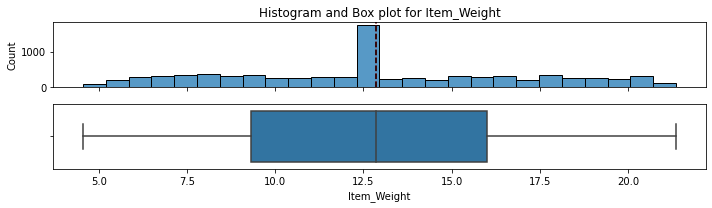

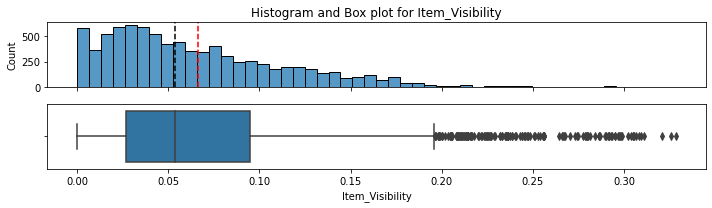

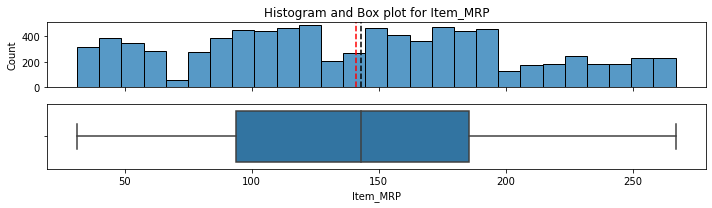

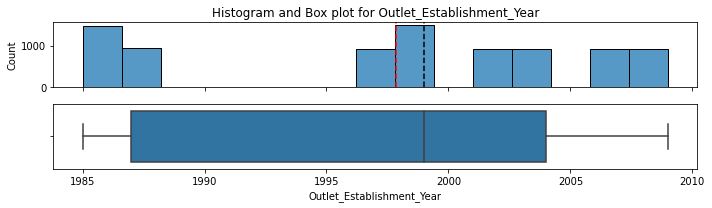

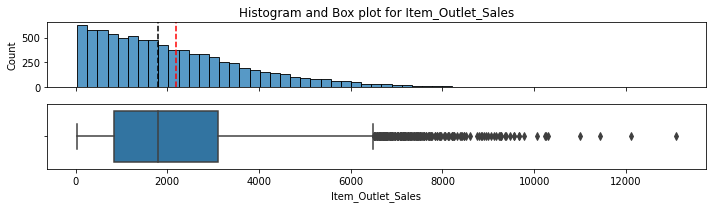

In [18]:
for col in num_cols:
  plot_charts(eda_df, col, boxplot=True)

### Numeric Data - Observations
>- `Item_Weight` : The majority of Items weigh about the same (12.5).   
- `Item_Visibility` : No Observations made
- `Item_MRP` : The Median MRP is aprox 140.  There are no outliers for MRP, which tells us we properly cleaned the data
- `Outlet_Establishment_Year` :  The outlet establishment dates were between 1987 and 2004.  The histogram shows that the greatest count of sales happened in the outlets established in 1985-86, and 1998-1999.  
- `Item_Outlet_Sales` : The median item_outlet_sales value is approx 1800.  This appears to show how frequently items are being sold in outlets.  There are many items that go way outside the 75% maximum of the barplot

##Categorical EDA (Histograms Only)

In [19]:
obj_cols = eda_df.select_dtypes('object').columns
#drop the "Item_Identifier" from out list
#obj_cols.drop(['Item_Identifier'])

#Drop the first item in the obj_cols - This is the "Item_Identifier" and is unique for each entry.  No relevant data from unique IDS
obj_cols

Index(['Item_Identifier', 'Item_Fat_Content', 'Item_Type', 'Outlet_Identifier',
       'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type'],
      dtype='object')

In [20]:
print(obj_cols[1:])

Index(['Item_Fat_Content', 'Item_Type', 'Outlet_Identifier', 'Outlet_Size',
       'Outlet_Location_Type', 'Outlet_Type'],
      dtype='object')


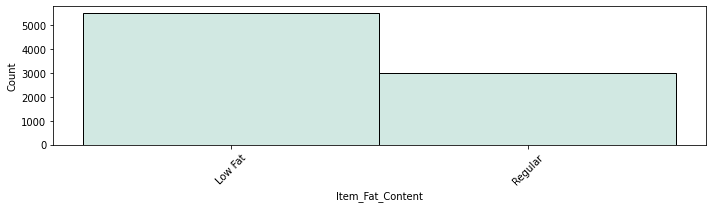

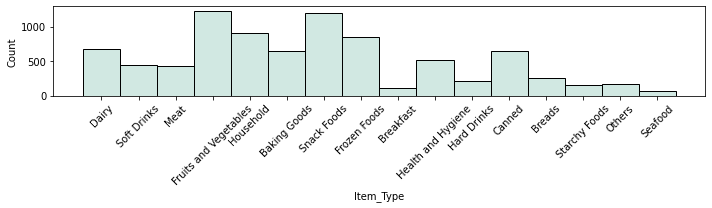

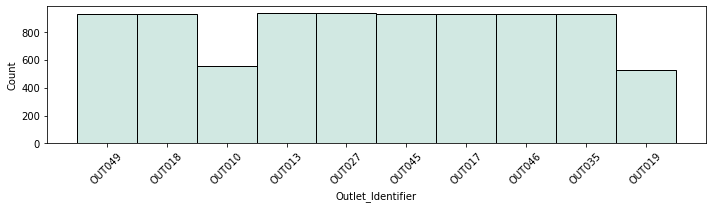

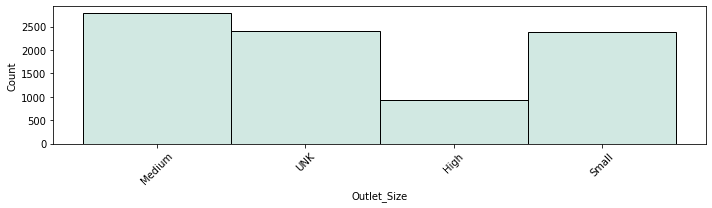

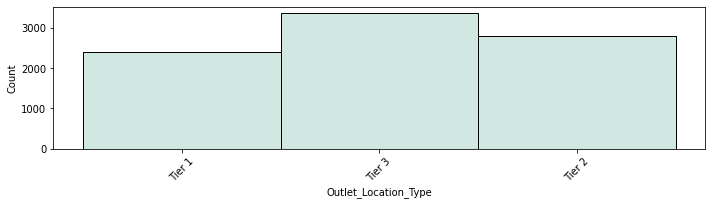

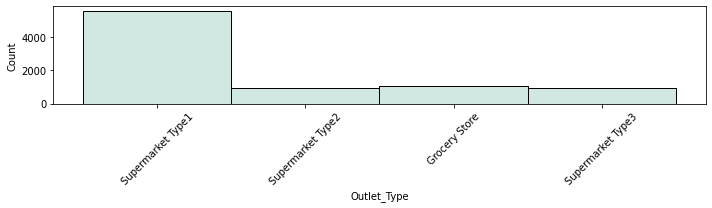

In [21]:
#Don't plot the Item_identifier since its a unique identifier
for col in obj_cols[1:]:
  plot_charts(eda_df, col, boxplot=False )

### Categorical Data- Obeservations
>When reviewing categorical data it is important to note that the output of the graphs is simply the count of occurances of that category type for the sale entries.  This does not reflect sales, but is rather a count of specific units sold and their accompanying data.
- `Item_Fat_Content` : *Low Fat* foods is make up a far greater count of total sales than the *Regular* foods.
- `Item_Types` : *Fruits and Vegetables* and *Snack Foods* are the two largest categories of 
- `Outlet_Identifier` : No observations made. This data is not relavant for analysis
- `Outlet_Size` : *Medium* and *Unknown* make up the two largest categories of outlet_size
- `Outlet_Location_Type`: *Tier 3* locations show the greatest number of sales followed by *Tier 2* and ulitimately *Tier 3* locations
- `Outlet_Type` : *Supermarket Type1* has the greatest count of sales by far. 

##Heatmap/Correlation

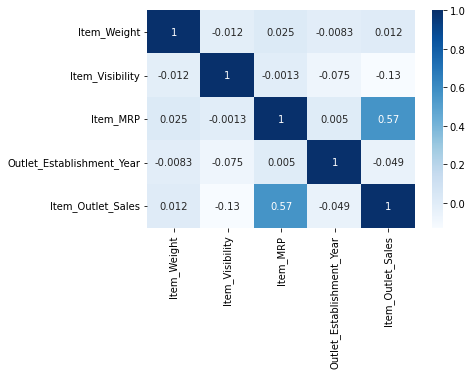

In [22]:
sns.heatmap(eda_df.corr(),annot=True,cmap='Blues');

### Heatmap Observations
>There is a "moderate" correlation between `Item_MRP` and `Item_Outlet_Sales`.  This relationship tells us that the higher `Item_MRP` leads to higher `Outlet_Sales`.  Although its only a "moderate" correlation it is telling us the customers purchase higher `Item_MRP` products more frequently.

##Multivariate analysis
The goal of this visual analaysis is to look at influences on total sales. As a business owner one would be interested in factors that are generating more revenue. In this example analysis we will look at the type of outlet and the type of product and how they influence overall sales. This is an introduction in use of grahping and formatting.

Questions

- What outlet type produces the most revenue?
- What product type produces the most revenue?


In [23]:
#Group by Outlet_Type and calculate total sales
OTS_sum_sort = eda_df.groupby("Outlet_Type")['Item_Outlet_Sales'].sum().sort_values(ascending=False)
OTS_sum_sort.head

<bound method NDFrame.head of Outlet_Type
Supermarket Type1    1.291734e+07
Supermarket Type3    3.453926e+06
Supermarket Type2    1.851823e+06
Grocery Store        3.680343e+05
Name: Item_Outlet_Sales, dtype: float64>

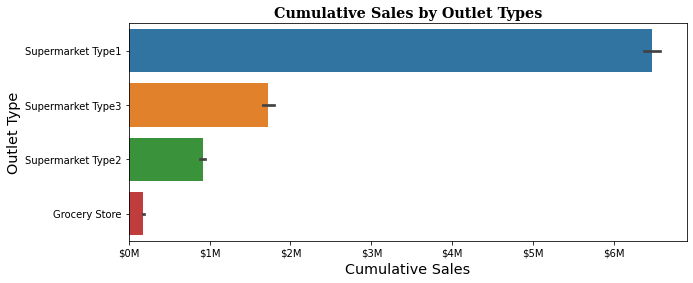

In [24]:
fig, ax = plt.subplots(figsize=(10,4));
sns.barplot(data = eda_df, 
            x = eda_df.groupby("Outlet_Type")['Item_Outlet_Sales'].cumsum(),
            order = OTS_sum_sort.index,
            y='Outlet_Type')

ax.set_title("Cumulative Sales by Outlet Types",
             fontfamily='serif',
             fontsize='x-large',
             fontweight='semibold');
ax.set_ylabel("Outlet Type",
              fontsize='x-large')
ax.set_xlabel("Cumulative Sales",
              fontsize='x-large')

# Create the formatter
price_fmt_m = FuncFormatter(million_m)
## Set the axis' major formatter
ax.xaxis.set_major_formatter(price_fmt_m)

With over $6M in sales, The Supermarket Type 1 is by far the highest grossing Outlet type. It generates more revenue than all other outlet types combined!

In [25]:
#Group by Item_Type and calculate Item total sales
IOS_sum_sort = eda_df.groupby(["Item_Type"])['Item_Outlet_Sales'].sum().sort_values(ascending=False)

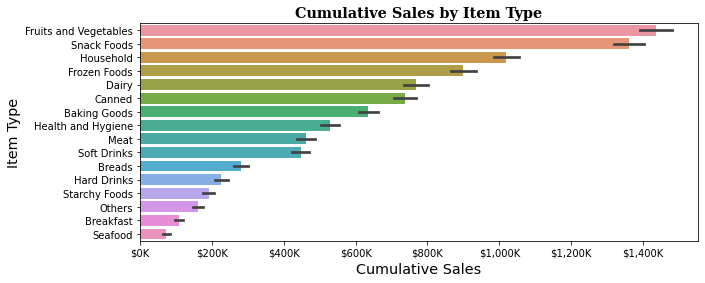

In [26]:
fig, ax = plt.subplots(figsize=(10,4));
sns.barplot(data = eda_df, 
            x=eda_df.groupby(["Item_Type"])['Item_Outlet_Sales'].cumsum(), 
            order = IOS_sum_sort.index,
            y="Item_Type");

ax.set_title("Cumulative Sales by Item Type",
             fontfamily='serif',
             fontsize='x-large',
             fontweight='semibold');

ax.set_ylabel("Item Type",
              fontsize='x-large')

ax.set_xlabel("Cumulative Sales",
              fontsize='x-large')

# Create the formatter
price_fmt_K = FuncFormatter(hundred_k)
## Set the axis' major formatter
ax.xaxis.set_major_formatter(price_fmt_K)

By plotting the cumulative sales of all the items we can see the following are the highest selling products. 

- Fruits and Vegetables > \$1.4M
- Snack Foods > \$1.3M
- Houshold > \$1M

#Data Preparation

##Train/Test Split

In [27]:
# Define features (X) and target (y)
target = 'Item_Outlet_Sales'
X = df.drop(columns = [target]).copy()
y = df[target].copy()

In [28]:
# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [29]:
X.columns

Index(['Item_Identifier', 'Item_Weight', 'Item_Fat_Content', 'Item_Visibility',
       'Item_Type', 'Item_MRP', 'Outlet_Identifier',
       'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type',
       'Outlet_Type'],
      dtype='object')

In [30]:
X_train.shape

(6392, 11)

In [31]:
X_test.shape

(2131, 11)

##Prepare Data

###Instantiate Imputers

In [32]:
#instantiate the StandardScaler to scale numerical data
scaler = StandardScaler()

#Use a 'mean-value' strategy for missing numeric data
mean_imputer = SimpleImputer(strategy='mean')

#Use a most_frequent strategy for missing ordinal data
freq_imputer = SimpleImputer(strategy='most_frequent')

#For missing values with nominal data, replace with 'UNK'
missing_imputer = SimpleImputer(strategy='constant', fill_value='UNK')

##Encoders
- We will use a One Hot Encoder for `Categorical:Nominal` and an Ordinal Encoder for `Categorical:Ordinal`.  Numeric values will be scalled with StandardScaler.
- Our ordinal entries need to be encoded to capture the realtive values in a non-language based style.

- `Item_Outlet_Size` - `Small:0`, `Medium:1`, `High:2`

###One Hot Encoder

In [33]:
#OneHot Encoder for categorical - nominal
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')

###Ordinal Encoder

In [34]:
#Ordinal encoder for categorical - ordinal data. We are looking at the Outlet_Size
os_labels = ['UNK','Small', 'Medium', 'High']

#handle_unknown is 'error' by default.  That's a good place to start
#but it may cause problems in a production model.  
ordinal = OrdinalEncoder(categories = [os_labels])

##Preprocessor Pipelines
The preprocessor pipelines pair the proper imputer and encoders.

In [35]:
# Setup the pipelines.  We pair the imputer with the Encoder
#numerical pipeline - mean_imputer/scaler encoder
num_pipeline = make_pipeline(mean_imputer, scaler)

#ordinal values -most frequent/ordinal encoder
ord_pipeline = make_pipeline(missing_imputer, ordinal)

#nominal values - missing imputer/ohe
nom_pipeline = make_pipeline(missing_imputer, ohe)

##Create Tuples
Use a tuple to pair the correct pipline with the data columns

In [36]:
# Create column lists for objects and a number selector
ordinal_cols = ['Outlet_Size']
nominal_cols = ['Item_Identifier',
                'Item_Fat_Content',
                'Item_Type',
                'Outlet_Identifier',
                'Outlet_Location_Type',
                'Outlet_Type']
#numeric column selector
num_selector = make_column_selector(dtype_include='number')

In [37]:
# Setup the tuples to pair the processors with the column selectors
numeric_tuple = (num_pipeline, num_selector)
ordinal_tuple = (ord_pipeline, ordinal_cols)
nominal_tuple = (nom_pipeline, nominal_cols)

In [38]:
# Instantiate the make column transformer.  Drop all columns not inlcuded in our selected lists
preprocessor = make_column_transformer(ordinal_tuple, 
                                       numeric_tuple, 
                                       nominal_tuple, 
                                       remainder='drop')

In [39]:
X_train.head

<bound method NDFrame.head of      Item_Identifier  Item_Weight Item_Fat_Content  Item_Visibility  \
4776           NCG06       16.350          Low Fat         0.029565   
7510           FDV57       15.250          Regular         0.000000   
5828           FDM27       12.350          Regular         0.158716   
5327           FDG24        7.975          Low Fat         0.014628   
4810           FDD05       19.350          Low Fat         0.016645   
...              ...          ...              ...              ...   
5734           FDY08        9.395          Regular         0.286345   
5191           FDC41       15.600          Low Fat         0.117575   
5390           NCQ53       17.600          Low Fat         0.018944   
860            FDL46       20.350          Low Fat         0.054363   
7270           NCN30       16.350          Low Fat         0.016993   

                  Item_Type  Item_MRP Outlet_Identifier  \
4776              Household  256.4646            OUT018   

In [40]:
# Fit the column transformer on the X_train
preprocessor.fit(X_train)

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='UNK',
                                                                strategy='constant')),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(categories=[['UNK',
                                                                              'Small',
                                                                              'Medium',
                                                                              'High']]))]),
                                 ['Outlet_Size']),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f0329970f40>),
                                ('pipeline-3',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='UNK',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 ['Item_Identifier', 'Item_Fat_Content',
                                  'Item_Type', 'Outlet_Identifier',
                                  'Outlet_Location_Type', 'Outlet_Type'])])

##Check Pipline and Data Transformation
Transform the data and look at the output shape and NaN count to make sure that our pipeline is working.  This is just a test and will not be used in our models since the data goes through the preprocessor transformation as part of the model pipeline

In [41]:
# Transform the X_train and the X_test
X_train_transformed = preprocessor.transform(X_train)
X_test_transformed = preprocessor.transform(X_test)
X_train_transformed.shape

(6392, 1590)

In [42]:
X_test_transformed.shape

(2131, 1590)

In [43]:
#Check that all values have been imputed
np.isnan(X_train_transformed).sum()

0

#Data Modeling
The following models will be used to determine the best strategy for predicting Outlet_Sales_Price.

* Linear Regression
* Decision Tree
* Bootstrapping Aggregating ("Bagged") Decision Tree
* Random Forrest 

As described in Data Preparation, the columns used to train our model are:
```
X = ['Item_Identifier', 'Item_Weight', 'Item_Fat_Content', 'Item_Visibility',
 'Item_Type', 'Item_MRP', 'Outlet_Identifier','Outlet_Establishment_Year',
  'Outlet_Size', 'Outlet_Location_Type','Outlet_Type']
```
and our target for analysis is `y = Item_Outlet_Sales`.

For each model we calculate the following:
 * **Mean Absolute Error (MAE)**: the average of the absolute difference between the actual and predicted values in the dataset. It measures the average of the residuals in the dataset.
 * **Mean Squared Error (MSE)**: the average of the squared difference between the original and predicted values in the data set. It measures the variance of the residuals.
 * **Root Mean Squared Error (RMSE)**: the square root of Mean Squared error. It measures the standard deviation of residuals.
 * **Coefficient of Determination (R2)**: the proportion of the variance in the dependent variable which is explained by the linear regression model. It is a scale-free score i.e. irrespective of the values being small or large, the value of R square will be less than one.

Finally, we compare the scores from each model to determine the best fit for our data.  

##Linear Regression Model
A fitted linear regression model can be used to identify the relationship between a single predictor variable xi and the response variable y when all the other predictor variables in the model are "held fixed".
The basic formula for a regression line is:
```
yhat = b0 + b1*x1 + b2*x2 + b3*x3 + ... + bi*xi

where:
    bi - coefficients
    xi = feature
```
The values that the model finds in order to determine the regression line are the *b’s*, the coefficient and the intercept, *b0*.

In [44]:
# Create an instance of the model
lin_reg = LinearRegression()

#Fit the preprocessed data to the model
lin_reg.fit(X_train_transformed, y_train)

LinearRegression()

###Evaluate Model

In [45]:
lr_report = evaluate_model(lin_reg, X_train_transformed, X_test_transformed, y_train, y_test, model_name='Linear Regression')

Linear Regression evaluation: 
Train MAE = 735.7241332603255
Test MAE = 172186933293.75107
Train MSE = 971594.3797688801
Test MSE = 5.34561560868001e+24
Train RMSE = 985.6948715342289
Test RMSE = 2312058738155.242
Train R2 = 0.6716982861805287
Test R2 = -1.9375351991134707e+18


The R2 value for the training data shows high correlation (67%), however in the test data we show an infinitely negative number.  Clearly this is not a good fit.

##Baseline (Dummy Regression)
The Dummy Regressor is a kind of Regressor that gives prediction based on simple strategies without paying any attention to the input Data.  In this case we implement the `strategy='mean'` which always predicts the mean of the training target values.

In [46]:
# Create an instance of the model
dummy = DummyRegressor(strategy='mean')

#Fit the model to the pre-processed data
dummy.fit(X_train_transformed, y_train)

DummyRegressor()

###Evaluate Model

In [47]:
dr_report = evaluate_model(dummy, X_train_transformed, X_test_transformed, y_train, y_test, model_name='Dummy Regression')  

Dummy Regression evaluation: 
Train MAE = 1360.2184410159132
Test MAE = 1326.121044678208
Train MSE = 2959455.7045265585
Test MSE = 2772144.4627103633
Train RMSE = 1720.306863477141
Test RMSE = 1664.9758144520788
Train R2 = 0.0
Test R2 = -0.004772483978719766


The Dummy(Mean Regression) model has a R2 value of 0 for training and a value of -0.4% for the test data.  This model does not fit our data well.

##Decision Tree
A *continuous variable decision tree*, or a *regression tree* is a type of supervised machine learning used to categorize or make predictions based on how a previous set of questions were answered. The model is a form of supervised learning, meaning that the model is trained and tested on a set of data that contains the desired categorization.

An overview of decision trees can be found [HERE](https://www.mastersindatascience.org/learning/machine-learning-algorithms/decision-tree/)

In [48]:
#Create the model
dec_tree = DecisionTreeRegressor(random_state = 42)

#Fit the trained data to the Decision tree
dec_tree.fit(X_train_transformed, y_train)

DecisionTreeRegressor(random_state=42)

In [49]:
#Evalute the model without tuning
dt_report = evaluate_model(dec_tree, X_train_transformed, X_test_transformed, y_train, y_test, model_name='Decision Tree')

Decision Tree evaluation: 
Train MAE = 1.2005415435245748e-16
Test MAE = 997.8173697794463
Train MSE = 2.4643264323299693e-29
Test MSE = 2148391.048858812
Train RMSE = 4.96419825584149e-15
Test RMSE = 1465.7390793926497
Train R2 = 1.0
Test R2 = 0.2213089037181779


The Decision Tree model has a perfect fit to the training data, but only a 22% fit to the test data.  Let's look at the structure of the decision tree and see if we can tune it to make a better fit.

###Tune Model
There are many hyperparameters we could look at when tuning the Decision tree, as seen below.  In this examination we will optomize for `max_depth`.  By calculating `R2` on the training and test data for varying values of max_Depth, we can maximize for R2 on test data.

In [50]:
# Display the list of available hyperparameters for tuning
dec_tree.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 42,
 'splitter': 'best'}

####Max_depth
From SciKit Learn [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html), we see that:

*The default values for the parameters controlling the size of the trees (e.g. max_depth, min_samples_leaf, etc.) lead to fully grown and unpruned trees which can potentially be very large on some data sets. To reduce memory consumption, the complexity and size of the trees should be controlled by setting those parameter values.*


In [51]:
# Obtain the max_depth from the pipeline and assign it to the variable max_depth
# The depth of a tree is the maximum distance between the root and any leaf.
max_depth=dec_tree.get_depth()
# Display max_depth
max_depth

60

In [52]:
# Create a range of max_depth values to evaluate
depths = range(1, max_depth+1)

# Create a dataframe to store Train and Test  R2 scores
scores = pd.DataFrame(columns=['Train Score', 'Test Score'], index=depths)

# Loop through the max_depth values
for depth in depths:
  # Create an instance of the model
  dec_tree = DecisionTreeRegressor(max_depth=depth, random_state = 42)
 
  # Fit the model
  dec_tree.fit(X_train_transformed, y_train)

  # Obtain the predictions from the model
  train_pred = dec_tree.predict(X_train_transformed)
  test_pred = dec_tree.predict(X_test_transformed)

  # Obtain the R2 scores for Train and Test
  train_r2score = r2_score(y_train, train_pred)
  test_r2score = r2_score(y_test, test_pred)

  # Save the Train and Test R2 Score for this depth in the scores dataframe
  scores.loc[depth, 'Train Score'] = train_r2score
  scores.loc[depth, 'Test Score'] = test_r2score

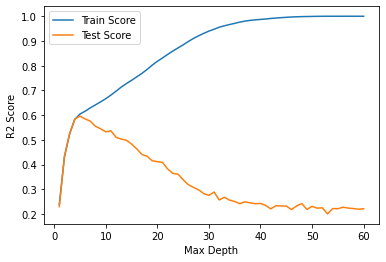

In [53]:
# Visualize the max_depths to display which achieves the highest R2 score
plt.plot(depths, scores['Train Score'], label='Train Score')
plt.plot(depths, scores['Test Score'], label='Test Score')
plt.ylabel('R2 Score')
plt.xlabel('Max Depth')
plt.legend()
plt.show()

>There is a clear divergence between training and test data around a `max_depth=5`.  By listing the values in descending order of `Test_R2` we can see the optimal depth

In [54]:
# Create a version on the scores dataframe
# sorted by highest Test Scores
sorted_scores = scores.sort_values(by='Test Score', ascending=False)
# Display the first (5) rows of the dataframe
sorted_scores.head()

,Train Score,Test Score
5,0.604207,0.596056
6,0.615702,0.584668
4,0.582705,0.583937
7,0.629269,0.575695
8,0.641322,0.554749


In [55]:
#sort the dataframe by test scores and save the index (k) of the best score
best_depth = sorted_scores.index[0]
best_depth

5

Refit the model to the optimal depth.

In [56]:
# Create an instance of the model
dec_tree = DecisionTreeRegressor(max_depth=best_depth, random_state = 42)

# Fit the model
dec_tree.fit(X_train_transformed, y_train);

###Evaluate Model

In [57]:
dt_report = evaluate_model(dec_tree, X_train_transformed, X_test_transformed, y_train, y_test, model_name='Decision Tree')

Decision Tree evaluation: 
Train MAE = 761.9784955008363
Test MAE = 736.8796499354125
Train MSE = 1171332.784431318
Test MSE = 1114471.1152767404
Train RMSE = 1082.281287111312
Test RMSE = 1055.6851402178304
Train R2 = 0.6042066848171654
Test R2 = 0.5960564372160062


The evaluation of the Decision Tree model shows a 60.4% fit to the training data an da 59.6% fit to the test data.  When we compare to the Dummy regression we see a lower MAE, lower MSE, and lower RMSE all of which indicate a better fit to the data.

##Bagged Tree
Bootstrap aggregation, or bagging, is a general-purpose procedure for reducing the variance of a statistical learning method. The algorithm constructs *B* regression trees using *B* bootstrapped training sets, and averages the resulting predictions. These trees are grown deep, and are not pruned. Hence each individual tree has high variance, but low bias. Averaging the B trees reduces the variance. The predicted value for an observation is the mode (classification) or mean (regression) of the trees.

In [58]:
#Instantiate the model
bagreg = BaggingRegressor(random_state = 42)

#Fit the model to the data
bagreg.fit(X_train_transformed, y_train);

In [59]:
bt_report = evaluate_model(bagreg, X_train_transformed, X_test_transformed, y_train, y_test, model_name='Bagged Tree')

Bagged Tree evaluation: 
Train MAE = 318.25957672403007
Test MAE = 790.1765014547161
Train MSE = 240820.75321720997
Test MSE = 1295486.7709336085
Train RMSE = 490.73491134950854
Test RMSE = 1138.1945224493081
Train R2 = 0.9186266742060478
Test R2 = 0.5304467431975487


###Tune Model

In [60]:
# Look at the hyperparameters
bagreg.get_params()

{'base_estimator': None,
 'bootstrap': True,
 'bootstrap_features': False,
 'max_features': 1.0,
 'max_samples': 1.0,
 'n_estimators': 10,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

####Vary `n_estimators`
This is the number of base classifiers that our model is going to aggregate together.

In [61]:
# List of estimator values
estimators = [10, 20, 30, 40, 50, 100, 150, 200, 250]
# Data frame to store the scores
scores = pd.DataFrame(index=estimators, columns=['Train Score', 'Test Score'])
# Iterate through the values to find the best number of estimators
for num_estimators in estimators:
 bag_reg = BaggingRegressor(n_estimators=num_estimators, random_state=42)

 #Fit the model to the data
 bag_reg.fit(X_train_transformed, y_train)

 train_score = bag_reg.score(X_train_transformed, y_train)
 test_score = bag_reg.score(X_test_transformed, y_test)
 scores.loc[num_estimators, 'Train Score'] = train_score
 scores.loc[num_estimators, 'Test Score'] = test_score

In [62]:
# Sort by test score
scores = scores.sort_values(by='Test Score', ascending=False)
scores

,Train Score,Test Score
250,0.939168,0.551563
200,0.938962,0.551076
150,0.93869,0.550611
100,0.937769,0.549405
50,0.935391,0.545601
40,0.934129,0.542425
30,0.932176,0.541733
20,0.92734,0.534934
10,0.918627,0.530447


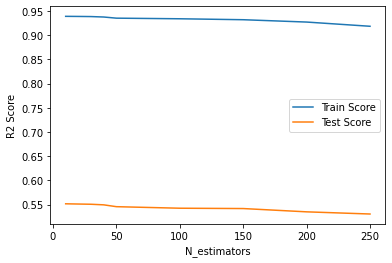

In [63]:
# Visualize the max_depths to display which achieves the highest R2 score
plt.plot(estimators, scores['Train Score'], label='Train Score')
plt.plot(estimators, scores['Test Score'], label='Test Score')
plt.ylabel('R2 Score')
plt.xlabel('N_estimators')
plt.legend()
plt.show()

>R2 value does not vary much with the n_estimators.  Let's try another hyperparameter `max_samples`

###Vary `max_samples`

In [64]:
#Vary the max_Samples
nsamples = np.arange(0.1,0.51, 0.05)
# Data frame to store the scores
scores2 = pd.DataFrame(index=nsamples, columns=['Train Score', 'Test Score'])
# Iterate through the values to find the best number of estimators
for num_samples in nsamples:
 print(num_samples)
 bag_reg = BaggingRegressor(max_samples=num_samples, random_state=42)

 #Fit the model to the data
 bag_reg.fit(X_train_transformed, y_train)

 train_score = bag_reg.score(X_train_transformed, y_train)
 test_score = bag_reg.score(X_test_transformed, y_test)
 scores2.loc[num_samples, 'Train Score'] = train_score
 scores2.loc[num_samples, 'Test Score'] = test_score

0.1
0.15000000000000002
0.20000000000000004
0.25000000000000006
0.30000000000000004
0.3500000000000001
0.40000000000000013
0.45000000000000007
0.5000000000000001


In [65]:
# Sort by test score
scores2 = scores2.sort_values(by='Test Score', ascending=False)
scores2

,Train Score,Test Score
0.15,0.663877,0.57098
0.10,0.641445,0.570393
0.30,0.736956,0.564016
0.25,0.718418,0.564011
0.45,0.79535,0.557862
0.20,0.694142,0.554502
0.40,0.779118,0.549396
0.35,0.759603,0.548328
0.50,0.812906,0.542902


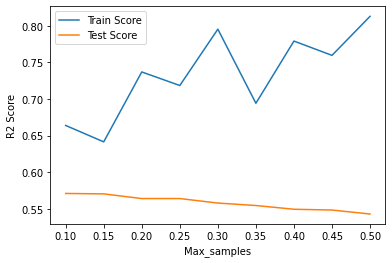

In [66]:
# Visualize the num_samples to display which achieves the highest R2 score
plt.plot(nsamples, scores2['Train Score'], label='Train Score')
plt.plot(nsamples, scores2['Test Score'], label='Test Score')
plt.ylabel('R2 Score')
plt.xlabel('Max_samples')
plt.legend()
plt.show()

> While the Training data fits better with a larger percentage of total samples in the data set, the Test data score slowly declines.  This is logical, if we had 100% of the training data in the sample set, the r2 value would be 100% as well, but the model would be overfit and the test data fit would suffer.

In [67]:
#Tune the model to the optimal N_estimator based on Test_R2.
best_n_samples = scores2.index[0]
# Instantiate and fit the best version of the model
bt_tuned = BaggingRegressor(max_samples = best_n_samples , random_state=42)

#Fit the data
bt_tuned.fit(X_train_transformed, y_train);

###Evaluate Model

In [68]:
bt_report = evaluate_model(bt_tuned, X_train_transformed, X_test_transformed, y_train, y_test, model_name='Bagged Tree')

Bagged Tree evaluation: 
Train MAE = 689.4713669743429
Test MAE = 755.769013486626
Train MSE = 994740.1813031896
Test MSE = 1183656.2970876687
Train RMSE = 997.3666233152128
Test RMSE = 1087.9596946062243
Train R2 = 0.6638773204877807
Test R2 = 0.5709800503545799


> After tuning our model for the max sample percent we fit the training data to 66.3% and the Test data to 57.1%.

##Random Forest
Random Forests offer a slight variation on bagged trees. The difference is that when building each tree, each time a split is considered, a random sample of m features is chosen as split candidates from the full set of p features. The split is only allowed to use one of those m features. This happens for every single tree at every single split

In [69]:
#Instantiate the model
rf = RandomForestRegressor(random_state = 42)

#Fit the model to training data
rf.fit(X_train_transformed, y_train)

RandomForestRegressor(random_state=42)

In [70]:
rf_report = evaluate_model(rf, X_train_transformed, X_test_transformed, y_train, y_test, model_name='Random Forest')

Random Forest evaluation: 
Train MAE = 297.06133280757194
Test MAE = 773.1621777268888
Train MSE = 184645.73457075196
Test MSE = 1244359.9834257883
Train RMSE = 429.7042408107604
Test RMSE = 1115.5088450683788
Train R2 = 0.9376082114395793
Test R2 = 0.5489778082171035


> Untuned Random Forest shows a 93.8% fit to the training data and 54.9% fit to the Test data.

###Tune Model
For the Random Forest model, I will tune the max_depth parameter and look at the output R2 test scores.  

In [71]:
# Look at the hyperparameters
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [72]:
#Display max depths
est_depths = [estimator.get_depth() for estimator in rf.estimators_]
max(est_depths)

87

>Looping through the depths, then reinstantiating the pipeline and model take A LOT of time.  If you can avoid re-running this please do!

In [73]:
#Evaluate Train/Test scores with varying max_depth hyperparameter
depths = range(1, max(est_depths))
rf_scores = pd.DataFrame(index=depths, columns=['Train Score', 'Test Score'])
for depth in depths:   
 
 rf = RandomForestRegressor(max_depth=depth, random_state=42)
 rf.fit(X_train_transformed, y_train)

 rf_scores.loc[depth, 'Train Score'] = rf.score(X_train_transformed, y_train)
 rf_scores.loc[depth, 'Test Score'] = rf.score(X_test_transformed, y_test)


In [74]:
rf_scores = rf_scores.sort_values(by='Test Score', ascending=False)
rf_scores

,Train Score,Test Score
6,0.625525,0.604093
5,0.61218,0.603884
7,0.639338,0.601892
8,0.654458,0.600945
9,0.670018,0.598809
...,...,...
50,0.936123,0.548364
54,0.936921,0.547571
3,0.544105,0.545162
2,0.462651,0.465954


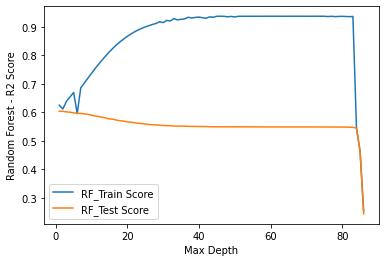

In [75]:
# Visualize the max_depths to display which achieves the highest R2 score
plt.plot(depths, rf_scores['Train Score'], label='RF_Train Score')
plt.plot(depths, rf_scores['Test Score'], label='RF_Test Score')
plt.ylabel('Random Forest - R2 Score')
plt.xlabel('Max Depth')
plt.legend()
plt.show()

We can see by sorting and plotting the R2 score over the 87 iterations of depth, that the optimal depth is 6.  The test score falls off as we continue to iterate through depths of our model.

In [76]:
#Tune the model to the optimal max_depth based on Test_R2.
best_depth = rf_scores.index[0]
# Instantiate and fit the best version of the model
rf_tuned = RandomForestRegressor(max_depth=best_depth, random_state=42)

#Fit the data
rf_tuned.fit(X_train_transformed, y_train);

###Evaluate Model

In [77]:
rf_report = evaluate_model(rf_tuned, X_train_transformed, X_test_transformed, y_train, y_test, model_name='Random Forest Tree')

Random Forest Tree evaluation: 
Train MAE = 745.3503338199347
Test MAE = 726.9327791559543
Train MSE = 1108241.4451012164
Test MSE = 1092297.245223045
Train RMSE = 1052.7304712514103
Test RMSE = 1045.1302527546723
Train R2 = 0.6255252466167565
Test R2 = 0.6040934261943834


The Random Forest model tuned to the best depth shows a 62.6% fit to the training data and a 60.4% fit to the test data. 

## Compare Models


In [78]:
report=[lr_report, dr_report, dt_report, bt_report, rf_report]
reportdf = pd.DataFrame(report)
reportdf

,Model,Train_MAE,Train_MSE,Train_RMSE,Train_R2,Test_MAE,Test_RMSE,Test_R2
0,Linear Regression,735.724133,9.715944e+05,985.694872,0.671698,5.345616e+24,985.694872,-1.937535e+18
1,Dummy Regression,1360.218441,2.959456e+06,1720.306863,0.000000,2.772144e+06,1720.306863,-4.772484e-03
2,Decision Tree,761.978496,1.171333e+06,1082.281287,0.604207,1.114471e+06,1082.281287,5.960564e-01
3,Bagged Tree,689.471367,9.947402e+05,997.366623,0.663877,1.183656e+06,997.366623,5.709801e-01
4,Random Forest Tree,745.350334,1.108241e+06,1052.730471,0.625525,1.092297e+06,1052.730471,6.040934e-01


Comparing the models, we see the best fit to the test data happens with a Random Forest Tree tuned for `max_depth`.  This regression model produced a coefficient of determination of 60.41%, a slightly better fit than the tuned Decision tree and Bagged Tree models.  

#Recomendation
Given the regression models used to explore this dataset, I would recomend using the Random Forest Tree model which produces a 62.5% fit to training data and a 60.4% fit to the test data.